In [8]:
using Flux

In [9]:
using ImageShow, Images, ImageInTerminal
using MLDatasets

In [10]:
train_x_raw, train_y_raw = MNIST(split = :train)[:]
test_x_raw,  test_y_raw  = MNIST(split = :test)[:];
println( "train_x_raw size = $(size(train_x_raw)), train_y_raw size = $(size(train_y_raw))")
display( train_y_raw[1:5] )

train_x_raw size = (28, 28, 60000), train_y_raw size = (60000,)


5-element Vector{Int64}:
 5
 0
 4
 1
 9

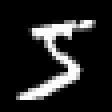

In [11]:
convert2image(MNIST, train_x_raw[ : , : , 1 ] )

## <span style="color:orange"> Create a 'Scale' layer which takes in inputs and scales the values linearly </span>

- Does not perform any transformations

In [12]:
m1 = Chain( Dense(1=>3) )

Chain(
  Dense(1 => 3),                        # 6 parameters
) 

In [13]:
fieldnames(typeof(m1.layers[1]))

(:weight, :bias, :σ)

In [14]:
m1.layers[1].weight

3×1 Matrix{Float32}:
  0.38271046
 -0.35430595
 -0.765652

In [15]:
m1( [1] ) #values returned / mapped 

3-element Vector{Float32}:
  0.38271046
 -0.35430595
 -0.765652

In [16]:
m1s = Flux.Scale( [0.1, 10, 100] ) #scaling layer

Scale(3)            # 6 parameters

In [17]:
m1scaled = Chain( m1 , m1s )

Chain(
  Chain(
    Dense(1 => 3),                      # 6 parameters
  ),
  Scale(3),                             # 6 parameters
)                   # Total: 4 arrays, 12 parameters, 360 bytes.

In [18]:
m1scaled( [1] )

3-element Vector{Float64}:
   0.03827104568481446
  -3.543059527873993
 -76.56520009040833

In [19]:
m1s2 = Flux.Scale( repeat( [0.01] , 3 ) ) #scaling layer

Scale(3)            # 6 parameters

In [20]:
m1scaled2 = Chain( m1 , m1s2 )

Chain(
  Chain(
    Dense(1 => 3),                      # 6 parameters
  ),
  Scale(3),                             # 6 parameters
)                   # Total: 4 arrays, 12 parameters, 360 bytes.

In [21]:
m1scaled2( [1] )

3-element Vector{Float64}:
  0.0038271045684814455
 -0.003543059527873993
 -0.007656520009040832

In [22]:
m1s3 = Flux.Scale( [1,0,1] ) #scaling layer which operates as a removing a neuron (dimension) component

Scale(3)            # 6 parameters

In [23]:
m1scaled3 = Chain( m1 , m1s3 )

Chain(
  Chain(
    Dense(1 => 3),                      # 6 parameters
  ),
  Scale(3),                             # 6 parameters
)                   # Total: 4 arrays, 12 parameters, 360 bytes.

In [24]:
m1scaled3( [1] )

3-element Vector{Float32}:
  0.38271046
  0.0
 -0.765652

## <span style="color:orange"> Convolution Models </span>

- Images (2D data) fed into CNN layers require the <u>W-H-C-N</u> order, which is Width-Height-ChannelNum-BatchSize. Eg if we have images width=28, height=28, 3 channels (R-G-B) and there are 100 of these images in the batch, the size of that data structure fed to the CNN layer is (28,28,3,100). If the images were monochromatic (gray scale) then the size would be (28,28,1,100). 
- Data can be 1D, for 1D convolutions, on time series or mono audio data, so that the format becomes W-C-N, eg. if we have 100 audio samples in one channel (mono) and each sample has 250 dimensions the size is, (250,1,1). If the data was stereo (2 channel) then the size would be (250,2,1)
- If the data was 3D (like data from a magnetic scan), it could look like this (28,28,28,1,100) where the last 2 dimensions are the channel number and batch size. 
- The Convolutional (CNN) layer takes in a <u>filter size</u> to scan over the data.
- The Convolutional (CNN) layer takes in the <u>channel size mapping</u>, which does a transformation from the input channel number to the output channel number. 
- Key parameter values are <u>stride</u>, <u>padding</u>, <u>dilation</u>
- Padding specifies the number of pixels (elements) placed on the borders (boundaries of the data in each dimension). A single value (integer) for uniform padding around the data array, or if there 3 spatial dimensions a tuple of 3 integers is needed to specify the padding if not uniform. You can supply a 2x3 = 6 dimension tuple to padding to specify the padding for each boundary specifically. **note padding will change the size of the image after the application of the cnn filter**
- <u>SamePad()</u> is a useful utility function so that it applies the necessary padding in order for the data dimensions to stay the same after the cnn filter application; that is a 28x28 image with SamePad() applied will still become 28x28 after exiting that layer and becoming input into the subsequent layer.


#### convolution gifs from [ Vincent Dumoulin, Francesco Visin - A guide to convolution arithmetic for deep learning]

### <span style="color:orange"> No padding, no strides </span>

![image info](./demoPics/no_padding_no_strides.gif)

In [25]:
x = rand(Float32, 100, 100, 1, 10); #batch of monochrome images
size( x )

(100, 100, 1, 10)

In [26]:
cnn_layer = Conv( (5,5) , 1 => 1 )

Conv((5, 5), 1 => 1)  # 26 parameters

In [27]:
cnn_output = cnn_layer(x)
size( cnn_output )

(96, 96, 1, 10)

In [28]:
size( x ) == size( cnn_output )

false

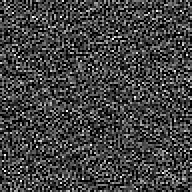

In [33]:
convert2image(MNIST,cnn_output[:,:,1,1])

### <span style="color:orange"> The data is in form WHN instead of WHCN so we must 'unsqueeze' the data to produce another dimension in the format</span>

In [37]:
size(Flux.unsqueeze(train_x_raw,dims=3))

(28, 28, 1, 60000)

In [40]:
images = Flux.unsqueeze(train_x_raw,dims=3);
images |> size

(28, 28, 1, 60000)

In [42]:
cnn_output = cnn_layer(images) |> size

(24, 24, 1, 60000)

In [47]:
images[:,:,:,1:3] |>size

(28, 28, 1, 3)

In [53]:
cnn_output = cnn_layer(images[:,:,:,1:3]) 
cnn_output |> size

(24, 24, 1, 3)

In [55]:
cnn_output[:,:,1,1] |>size

(24, 24)

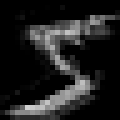

In [56]:
convert2image(MNIST,cnn_output[:,:,1,1])

In [66]:
cnn_layer2 = Conv( (5,5) , 1 => 1 , pad = 2 ) #apply some padding

Conv((5, 5), 1 => 1, pad=2)  # 26 parameters

In [67]:
cnn_output2 = cnn_layer2( x )
size( cnn_output2 )

(100, 100, 1, 10)

In [68]:
size( x ) == size( cnn_output2 )

true

In [69]:
cnn_output = cnn_layer2(images[:,:,:,1:3])
cnn_output |> size

(28, 28, 1, 3)

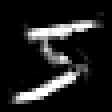

In [70]:
convert2image(MNIST,cnn_output[:,:,1,1])

#### <span style="color:orange"> try SamePad() </span>

In [71]:
cnn_layer3 = Conv( (5,5) , 1 => 1 , pad = SamePad() ) #apply some padding using the SamePad() function helper

Conv((5, 5), 1 => 1, pad=2)  # 26 parameters

In [72]:
cnn_output3 = cnn_layer3( x )
size( cnn_output3 )

(100, 100, 1, 10)

In [73]:
size( x ) == size( cnn_output3 )

true

<span style="color:orange"> What happens to the size on repeated applications of a filter </span>

In [75]:
x = rand(Float32, 100, 100, 1, 10); #batch of monochrome images

In [76]:
cnn_layer = Chain( Conv( (5,5) , 1=>3 ) , Conv( (5,5) , 3=>5 ) , Conv( (5,5) , 5=>1 ) ) 

Chain(
  Conv((5, 5), 1 => 3),                 # 78 parameters
  Conv((5, 5), 3 => 5),                 # 380 parameters
  Conv((5, 5), 5 => 1),                 # 126 parameters
)                   # Total: 6 arrays, 584 parameters, 3.336 KiB.

In [77]:
cnn_output = cnn_layer( x )
size( cnn_output )

(88, 88, 1, 10)

(16, 16, 1, 3)

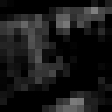

In [79]:
cnn_output = cnn_layer(images[:,:,:,1:3])
display( cnn_output |> size )
convert2image(MNIST,cnn_output[:,:,1,1])

In [86]:
cnn_layer_same_pad = Chain( Conv((5,5),1=>3,pad=SamePad()),Conv((5,5),3=>5,pad=SamePad()),Conv((5,5),5=>1,pad=SamePad()) ) 

Chain(
  Conv((5, 5), 1 => 3, pad=2),          # 78 parameters
  Conv((5, 5), 3 => 5, pad=2),          # 380 parameters
  Conv((5, 5), 5 => 1, pad=2),          # 126 parameters
)                   # Total: 6 arrays, 584 parameters, 3.336 KiB.

In [87]:
cnn_layer_same_pad_res = cnn_layer_same_pad( x )
size( cnn_layer_same_pad_res )

(100, 100, 1, 10)

(28, 28, 1, 3)

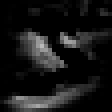

In [88]:
cnn_output = cnn_layer_same_pad(images[:,:,:,1:3])
display( cnn_output |> size )
convert2image(MNIST,cnn_output[:,:,1,1])

In [89]:
cnn_layer_same_pad2 = Chain( Conv((5,5),1=>3,pad=SamePad()),Conv((5,5),3=>5,pad=SamePad()),Conv((5,5),5=>8,pad=SamePad()) ) 
cnn_layer_same_pad_res = cnn_layer_same_pad2( x )
size( cnn_layer_same_pad_res )

(100, 100, 8, 10)

(28, 28, 8, 3)

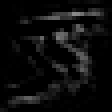

In [90]:
cnn_output = cnn_layer_same_pad2(images[:,:,:,1:3])
display( cnn_output |> size )
convert2image(MNIST,cnn_output[:,:,1,1])

### <span style="color:orange"> Example like the gif above </span>

In [30]:
x = rand(Float32, 4, 4, 1, 10); #batch of monochrome images
cnn_layer = Conv( (3,3) , 1 => 1 )
cnn_layer( x ) |> size

(2, 2, 1, 10)

### <span style="color:orange"> Add arbitrary padding (zeros) </span>

![image info](./demoPics/arbitrary_padding_no_strides.gif)

In [31]:
x = rand(Float32, 4, 4, 1, 1); #batch of monochrome images
cnn_layer = Conv( (3,3) , 1 => 1 , pad = 5)
println( cnn_layer( x ) |> size )
cnn_layer( x )

(12, 12, 1, 1)


12×12×1×1 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0   0.0        0.0       …   0.0         0.0  0.0  0.0
 0.0  0.0  0.0   0.0        0.0           0.0         0.0  0.0  0.0
 0.0  0.0  0.0   0.0        0.0           0.0         0.0  0.0  0.0
 0.0  0.0  0.0  -0.516098  -0.637606     -0.0722668   0.0  0.0  0.0
 0.0  0.0  0.0  -0.59015   -0.15906      -0.279384    0.0  0.0  0.0
 0.0  0.0  0.0   0.131151  -0.41631   …   0.236352    0.0  0.0  0.0
 0.0  0.0  0.0  -0.480828  -1.10059       0.0967512   0.0  0.0  0.0
 0.0  0.0  0.0  -0.388956   0.210032      0.164969    0.0  0.0  0.0
 0.0  0.0  0.0   0.238831   0.634291     -0.00617969  0.0  0.0  0.0
 0.0  0.0  0.0   0.0        0.0           0.0         0.0  0.0  0.0
 0.0  0.0  0.0   0.0        0.0       …   0.0         0.0  0.0  0.0
 0.0  0.0  0.0   0.0        0.0           0.0         0.0  0.0  0.0

In [32]:
x = rand(Float32, 4, 4, 1, 1); 
cnn_layer = Conv( (3,3) , 1 => 1 , pad = (0,5) ) #non-uniform padding
println( cnn_layer( x ) |> size )
cnn_layer( x )

(2, 12, 1, 1)


2×12×1×1 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  -0.611332  -0.695477  -0.597909  …   0.101236   0.0  0.0  0.0
 0.0  0.0  0.0  -0.815298  -0.460176  -0.282421     -0.0336858  0.0  0.0  0.0

### <span style="color:orange"> On 1D data </span>

In [33]:
x = rand(Float32, 100, 1, 1); #100elements, 1 channel, 10 samples in the batch 
cnn_layer = Conv( (4,) , 1 => 1 ) #4 element filter
cnn_layer( x ) |> size

(97, 1, 1)

In [34]:
x = rand(Float32, 100, 1, 1); #100elements, 1 channel, 10 samples in the batch 
cnn_layer = Conv( (4,) , 1 => 1 , pad = SamePad() ) #4 element filter
cnn_layer( x ) |> size

(100, 1, 1)

### <span style="color:orange"> Now apply 'Strides' </span>
![image info](./demoPics/no_padding_strides.gif)

(no padding but with strides)

In [35]:
x = rand(Float32, 100, 1, 1); #100elements, 1 channel, 10 samples in the batch 
cnn_layer = Conv( (4,) , 1 => 1 , stride=5 ) #4 element filter
cnn_layer( x ) |> size

(20, 1, 1)

In [36]:
x = rand(Float32, 100, 1, 1); #100elements, 1 channel, 10 samples in the batch 
cnn_layer = Conv( (4,) , 1 => 1 , stride=1 ) 
cnn_layer( x ) |> size

(97, 1, 1)

In [37]:
x = rand(Float32, 50, 50, 2, 10); #batch of monochrome images
cnn_layer = Conv( (3,3) , 2 => 3 , stride = 5 )
cnn_layer( x ) |> size

(10, 10, 3, 10)

### <span style="color:orange"> Padding and Strides </span>

![image info](./demoPics/padding_strides.gif)

In [38]:
x = rand(Float32, 200, 200, 3, 10); #batch of monochrome images
cnn_layer = Conv( (4,4) , 3 => 3 , pad=4 , stride = 5 )
cnn_layer( x ) |> size

(41, 41, 3, 10)

### <span style="color:orange"> Dilation, adds element skipping between element of the filter </span>

![image info](./demoPics/dilation.gif)

In [39]:
x = rand(Float32, 200, 200, 3, 10); 
cnn_layer = Conv( (4,4) , 3 => 3 , dilation = 1 )
cnn_layer( x ) |> size

(197, 197, 3, 10)

In [40]:
x = rand(Float32, 200, 200, 3, 10); 
cnn_layer = Conv( (4,4) , 3 => 3 , dilation = 2 )
cnn_layer( x ) |> size

(194, 194, 3, 10)

In [41]:
x = rand(Float32, 200, 200, 3, 10); 
cnn_layer = Conv( (5,5) , 3 => 3 , pad = 2 , dilation=1 )
cnn_layer( x ) |> size

(200, 200, 3, 10)

In [42]:
x = rand(Float32, 200, 200, 1, 10); 
cnn_layer = Conv( (5,5) , 1 => 1 , pad = 2 , dilation=4 )
cnn_layer( x ) |> size

(188, 188, 1, 10)

(16, 16, 1, 3)

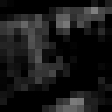

In [91]:
cnn_output = cnn_layer( images[:,:,:,1:3] )
display( cnn_output |> size )
convert2image( MNIST , cnn_output[:,:,1,1] )

In [93]:
x = rand(Float32, 200, 200, 1, 10); 
cnn_layer = Conv( (5,5) , 1 => 1 , pad = SamePad() , dilation=4 )
cnn_layer( x ) |> size

(200, 200, 1, 10)

(28, 28, 1, 3)

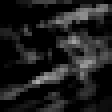

In [94]:
cnn_output = cnn_layer( images[:,:,:,1:3] )
display( cnn_output |> size )
convert2image( MNIST , cnn_output[:,:,1,1] )

## <span style="color:orange"> Transposed convolutional  </span>

- Transposed convolutional layers 'upsample' the data, so that the output feature map goes from 'low' resolution to 'high' resolution.
- Previously the operations would 'downsample' that reduces resolution.
- Increases the size of the output
- Takes each kernel element and projects onto the surroundings to create a patch

![image info](./demoPics/no_padding_no_strides_transposed.gif)

(transposed convolution, no padding no strides)

![image info](./demoPics/full_padding_no_strides_transposed.gif)

(transposed convolution, full padding no strides)

![image info](./demoPics/padding_strides_transposed.gif)

(transposed convolution, padding no strides)

In [95]:
x = rand(Float32, 10, 10, 1, 10); 
cnn_layer = ConvTranspose( (5,5) , 1 => 1  )
cnn_layer( x ) |> size

(14, 14, 1, 10)

(32, 32, 1, 3)

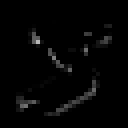

In [96]:
cnn_output = cnn_layer( images[:,:,:,1:3] )
display( cnn_output |> size )
convert2image( MNIST , cnn_output[:,:,1,1] )

In [45]:
x = rand(Float32, 10, 10, 1, 10); 
cnn_layer = ConvTranspose( (5,5) , 1 => 1 , pad=6 )
cnn_layer( x ) |> size

(2, 2, 1, 10)

(32, 32, 1, 3)

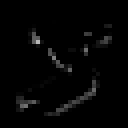

In [97]:
cnn_output = cnn_layer( images[:,:,:,1:3] )
display( cnn_output |> size )
convert2image( MNIST , cnn_output[:,:,1,1] )

In [98]:
x = rand(Float32, 10, 10, 1, 10); 
cnn_layer = ConvTranspose( (5,5) , 1 => 1 , pad=1 , stride=2 )
cnn_layer( x ) |> size

(21, 21, 1, 10)

(57, 57, 1, 3)

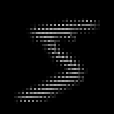

In [99]:
cnn_output = cnn_layer( images[:,:,:,1:3] )
display( cnn_output |> size )
convert2image( MNIST , cnn_output[:,:,1,1] )

In [100]:
x = rand(Float32, 10, 10, 1, 10); 
cnn_layer = ConvTranspose( (5,5) , 1 => 1 , pad=SamePad() , stride=2 )
cnn_layer( x ) |> size

(20, 20, 1, 10)

(56, 56, 1, 3)

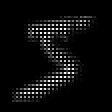

In [101]:
cnn_output = cnn_layer( images[:,:,:,1:3] )
display( cnn_output |> size )
convert2image( MNIST , cnn_output[:,:,1,1] )

In [102]:
x = rand(Float32, 10, 10, 1, 1); 
cnn_layer = ConvTranspose( (5,5) , 1 => 1 , pad=SamePad() , stride=4 )
cnn_layer( x ) 

40×40×1×1 Array{Float32, 4}:
[:, :, 1, 1] =
 -0.0119461    0.0330568   0.0595997  …   0.0389195   -0.00426853
  0.0361941   -0.0488861   0.0617708      0.0403372    0.000216651
 -0.00844998  -0.0678204  -0.027328      -0.0178456    0.0368818
  0.326001    -0.316403    0.0935666      0.0754568   -0.178244
 -0.0526916    0.145805    0.26288        0.203351    -0.0223027
  0.159643    -0.215625    0.272456   …   0.210758     0.00113198
 -0.0372708   -0.299139   -0.120537      -0.0932416    0.192704
  0.335558    -0.354552   -0.0137535     -0.0536514   -0.0518787
 -0.0437493    0.121061    0.218267       0.0739067   -0.00810579
  0.13255     -0.179031    0.226218       0.0765989    0.000411412
 -0.0309456   -0.248372   -0.100081   …  -0.0338881    0.0700372
  0.179979    -0.201237   -0.0495758      0.0719903   -0.198488
 -0.0194445    0.0538058   0.0970092      0.22879     -0.0250927
  ⋮                                   ⋱               
 -0.0271381    0.0750953   0.135393       0.020489  

(112, 112, 1, 3)

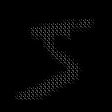

In [103]:
cnn_output = cnn_layer( images[:,:,:,1:3] )
display( cnn_output |> size )
convert2image( MNIST , cnn_output[:,:,1,1] )

#### <span style="color:orange"> Depthwise Convolutional Layers apply kernels to each channel separately so that the kernel does not span all channels </span>

In [104]:
x = rand(Float32, 10, 10, 5, 10); 
cnn_layer = DepthwiseConv( (5,5) , 5 => 5 , pad=SamePad() )
cnn_layer( x ) |> size

(10, 10, 5, 10)

### <span style="color:orange"> Common layers often used 'after' a CNN layer </span>

- they reduce the size of the output, and do not have parameters to train
- MaxPool, takes the maximum element in the region, and the corresponding 'MeanPool' exists
- Adaptive Max Pool, this takes in a tuple for the size of the data desired for each channel and batch size and finds for you the MaxPool size for the target output size needed. (equivalently there is the AdaptiveMeanPool)

- GlobalMaxPool produces a single value for each of the channels and each of the batch samples (also GlobalMeanPool is there)

In [105]:
x = rand(Float32, 100, 100, 1, 10); 
m = Chain( Conv( (5,5) , 1 => 2 ) , MaxPool((5,5)) )
m( x ) |> size

(19, 19, 2, 10)

(4, 4, 2, 3)

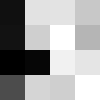

In [106]:
cnn_output = m( images[:,:,:,1:3] )
display( cnn_output |> size )
convert2image( MNIST , cnn_output[:,:,1,1] )

In [108]:
x = rand(Float32, 100, 100, 1, 10); 
m = Chain( Conv( (5,5) , 1 => 2 , pad=SamePad() ) , MaxPool((5,5)) )
m( x ) |> size

(20, 20, 2, 10)

(5, 5, 2, 3)

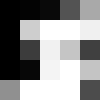

In [109]:
cnn_output = m( images[:,:,:,1:3] )
display( cnn_output |> size )
convert2image( MNIST , cnn_output[:,:,1,1] )

In [113]:
x = rand(Float32, 100, 100, 1, 10); 
m = Chain( Conv( (5,5) , 1 => 2  ) , MaxPool( (5,5), pad=SamePad() ) )
m( x ) |> size

(20, 20, 2, 10)

In [114]:
x = rand(Float32, 100, 100, 1, 10); 
m = Chain( Conv( (5,5) , 1 => 2  ) , AdaptiveMaxPool( (40,40) ) ) #we want a 40x40 output from MaxPool
m( x ) |> size

(40, 40, 2, 10)

In [116]:
x = rand(Float32, 100, 100, 1, 10); 
m = Chain( Conv( (5,5) , 1 => 3  ) , GlobalMaxPool() ) #we want a 40x40 output from MaxPool
m( x ) |> size

(1, 1, 3, 10)

### <span style="color:orange"> Upsampling </span>

- These do the opposite of pooling. Instead of a transposed convolution these layers 'upsample' by increasing the resolution from the perspective of further interpolating across the domain in the statistical sense. 
- There are different methods for doing so, such as the bilinear and nearest

In [122]:
x = rand(Float32, 100, 100, 2, 10); 
m = Upsample( :nearest, size= (200,200) )
m( x ) |> size

(200, 200, 2, 10)

In [125]:
x = rand(Float32, 28, 28, 2, 10); 
m = Upsample( :nearest, size= (28*10,28*10) )
m( x ) |> size

(280, 280, 2, 10)

(280, 280, 1, 3)

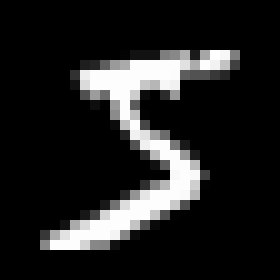

In [126]:
cnn_output = m( images[:,:,:,1:3] )
display( cnn_output |> size )
convert2image( MNIST , cnn_output[:,:,1,1] )

In [129]:
x = rand(Float32, 100, 100, 2, 10); 
m = Upsample( :bilinear, scale=10 )
m( x ) |> size

(1000, 1000, 2, 10)

(280, 280, 1, 3)

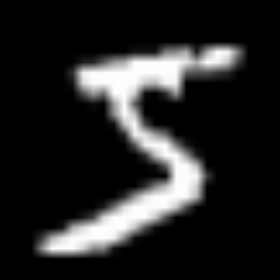

In [130]:
cnn_output = m( images[:,:,:,1:3] )
display( cnn_output |> size )
convert2image( MNIST , cnn_output[:,:,1,1] )

### <span style="color:orange"> Layer level functions </span>

- We can have layers that are functions of layers
- eg. 'Maxout' which takes in a set of layers where each gets fed the same input, and then produces the maximum from each output
- 'activations' which returns the output from each layer
- 'parallel' that is a layer which passes an input array into each layer in a set and then a function merges (reduces) these layer outputs

In [131]:
x = rand(Float32, 100, 1, 1); #100elements, 1 channel, 10 samples in the batch 
cnn_layer = Conv( (4,) , 1 => 1 ) #4 element filter
cnn_layer( x ) |> size

(97, 1, 1)

In [132]:
x = rand(Float32, 50, 10);
m = Chain( Dense(50=>10), Dense(10=>5), Dense(5=>1) )
res = Flux.activations(m,x)
println(length(res))
display(res[1])
display(res[2])
display(res[3])

3


10×10 Matrix{Float32}:
 -0.399328     0.0760445   0.871108   …   0.516235    0.739331   0.78714
 -0.100741     0.202583   -0.693497      -0.321393   -0.127195   0.365254
  0.475157     0.297879    0.539067       0.0387698   0.182239  -0.106542
 -0.306768    -0.560046   -0.579755      -0.975201   -0.456696  -0.766125
 -0.403551     0.640238    0.498729       0.476726    1.01766    0.202576
  1.24741      2.1034      2.02862    …   1.62772     1.69147    1.08707
 -0.00884771  -0.277226   -0.0824485     -0.420657   -0.578645  -0.197409
 -0.130242    -0.652528   -0.593686       0.498859    0.505471  -0.197141
  0.0296733   -0.334418    0.195391      -0.30445    -0.119436   0.233789
  0.179215     0.360399    0.288385       0.0169251   0.783229  -0.0436499

5×10 Matrix{Float32}:
 -0.952944  -1.52144   -1.59779   …  -0.941566  -1.45855    -0.344095
 -0.390894   0.367682  -0.203505      0.649967   1.18733     0.403731
  1.14596    1.0904     1.36609       1.0537     0.495952    0.89529
 -0.607759  -1.30913   -2.03014      -0.626309  -0.962691   -0.564924
  0.243959  -0.043168   0.619059      0.820755   0.0323841   0.275044

1×10 Matrix{Float32}:
 0.924873  0.0134082  1.62699  -0.995293  …  0.552321  -1.19354  0.681168

In [59]:
x = rand(Float32, 10, 4);
m = Maxout( Dense(10=>5), Dense(10=>5), Dense(10=>5) )
m(x)

5×4 Matrix{Float32}:
  0.150559   0.654824    0.731266    0.782263
  0.216073   0.575891    0.142889    0.449494
  0.228694   0.0191426   0.0298108  -0.284264
 -0.574127  -0.143012   -0.148505    0.110705
  0.573039   0.336649    0.433287    0.399928

In [60]:
x = rand(Float32, 10, 4);
m = Chain( Dense(10=>5) , Dense(5=>2) )
#takes in the layer and the 'connection function'
m_skip = SkipConnection( m , (mx,x) -> cat(mx,x,dims=1) ) #add a shortcut for the layer input to the output
m_skip(x)

12×4 Matrix{Float32}:
  0.248707   1.46678    0.569922    1.87419
 -0.0816642  0.243273  -0.565229   -0.554613
  0.550014   0.125127   0.916952    0.519952
  0.981695   0.735799   0.991014    0.978413
  0.795676   0.49258    0.0212672   0.114624
  0.777628   0.752816   0.0285347   0.961091
  0.364511   0.491473   0.148388    0.803039
  0.387119   0.446076   0.926738    0.0734932
  0.193289   0.719858   0.933196    0.82026
  0.768382   0.95945    0.582951    0.19
  0.290165   0.476125   0.371995    0.122148
  0.102595   0.983255   0.154041    0.959871

In [61]:
x = rand(Float32, 10,10, 3, 4);
m = Chain( Conv((3,3), 3=>5, pad=SamePad()) )
#takes in the layer and the 'connection function'
m_skip = SkipConnection( m , (mx,x) -> cat(mx,x,dims=3) ) #add a shortcut for the layer input to the output
m_skip(x) |> size

(10, 10, 8, 4)

In [62]:
x = rand(Float32, 10,10, 3, 4);
m_parallel = Parallel( + , Conv((3,3), 3=>5), Conv((3,3), 3=>5), Conv((3,3), 3=>5) )
m_parallel( x ) |> size

(8, 8, 5, 4)

### <span style="color:orange"> Normalization and Regularization </span>

- Although they can be done (as demonstrated earlier) in the approach commonly found in statistics, there are ways to do this in the ML fashion

In [63]:
#Batch Normalization
x = rand(Float32, 10,10, 3, 4);
m = BatchNorm( 3 )
display( m( x ) |> size )
m = Chain( Conv((3,3),3=>1) , BatchNorm(1) )
m( x ) |> size

(10, 10, 3, 4)

(8, 8, 1, 4)

In [64]:
#Dropout layer
x = rand(Float32, 10, 4)
m = Chain( Dense(10 => 5), Dropout(0.5) )
Flux.trainmode!(m)
m( x ) #notice the zeros

5×4 Matrix{Float32}:
  0.0       0.0  -0.0        0.0
  0.48666   0.0   0.0        0.0
 -0.0      -0.0   0.311387  -0.0
  0.0       0.0   0.0        1.5902
 -1.97138  -0.0  -1.30835   -2.49288

In [65]:
x = rand(Float32, 10,10, 3, 4)
m = Chain( Conv((4,4), 3=>3), Dropout(0.5, dims=3) ) #dropping out on the channels
Flux.trainmode!(m)
m( x ) |> size

(7, 7, 3, 4)

In [66]:
#LayerNorm does normalization and is used in recurrence networks
x = rand(Float32, 10, 4)
m = Chain( Dense(10=>5) , LayerNorm(5) )
display( size( m( x ) ) )
display( sum( m(x) , dims=1 ) )

(5, 4)

1×4 Matrix{Float32}:
 1.19209f-7  -1.19209f-7  1.04308f-7  2.98023f-7

In [67]:
#Instance Normalization layer to normalize channels in WHCN
x = rand(Float32, 10,10, 3, 4)
m = Chain( Conv((3,3),3=>5) , InstanceNorm(5) )
m( x ) |> size

(8, 8, 5, 4)

In [68]:
#we can do normalization outside of a layer
x = rand(Float32, 5, 4)
Flux.normalize( x )

5×4 Matrix{Float32}:
 0.244559  0.0277367  0.226669   0.132
 0.175455  0.171288   0.0970931  0.189409
 0.106477  0.232003   0.21215    0.31107
 0.144144  0.338041   0.101241   0.327354
 0.369147  0.279377   0.167223   0.252018

In [69]:
#we can do dropout outside of a layer
x = rand(Float32, 6, 4)
Flux.dropout( x , 0.5 , dims=1 )

6×4 Matrix{Float32}:
 0.0       0.0      0.0      0.0
 0.0       0.0      0.0      0.0
 0.0       0.0      0.0      0.0
 0.0       0.0      0.0      0.0
 0.601625  1.78619  1.20431  1.527
 0.0       0.0      0.0      0.0

### <span style="color:orange"> Autosizing </span>

- Sometimes if there are many layers in a Chain it becomes a challenge to track the dimension changes for the transformations on the data sizes if you change some aspect the sizes need to be re-entered. This is especially hazardous when working with CNN layers where padding and resolution changes can alter the dimensions (shape) of the data. 
- There is a macro <u>autosize</u> that can act on the layers to replace the character *_* with the necessary size. (calculates in run time)
- There is the function *outputsize* that does this operation

In [82]:
x = rand(Float32, 10,10, 3, 4);
x_size = size(x)

(10, 10, 3, 4)

In [85]:
m = @autosize (10,10, 3, 4) Chain(Conv((3, 3), _ => 5, relu, stride=2), Flux.flatten, Dense(_ => 10))

Chain(
  Conv((3, 3), 3 => 5, relu, stride=2),  # 140 parameters
  Flux.flatten,
  Dense(80 => 10),                      # 810 parameters
)                   # Total: 4 arrays, 950 parameters, 4.188 KiB.

In [87]:
m[3]

Dense(80 => 10)     # 810 parameters

In [92]:
m = @autosize (x_size[1],x_size[2],x_size[3],x_size[4]) Chain( Conv( ( 3 , 3 ) , _ => 5 , relu , stride=2 ), Flux.flatten , Dense( _ => 10 ) )

Chain(
  Conv((3, 3), 3 => 5, relu, stride=2),  # 140 parameters
  Flux.flatten,
  Dense(80 => 10),                      # 810 parameters
)                   # Total: 4 arrays, 950 parameters, 4.188 KiB.

### <span style="color:orange"> testmode! and trainmode! </span>

- manually specify to the models if you are training or testing
- so that layers like dropout are not randomly working on the forward steps

In [74]:
testmode!(m, true)

Chain(
  Conv((3, 3), 3 => 5),                 # 140 parameters
  InstanceNorm(5, affine=false),
) 

In [75]:
trainmode!(m, true)

Chain(
  Conv((3, 3), 3 => 5),                 # 140 parameters
  InstanceNorm(5, affine=false),
) 

important function utilities ; Flux.flatten    

In [72]:
![image info](./demoPics/arbitrary_padding_no_strides.gif)

LoadError: syntax: "./" is not a unary operator

In [73]:
<span style="color:orange">  </span>

LoadError: syntax: "<" is not a unary operator